# Exploratory Data Analysis

Having completed basic data transformation it's time to see what's inside. It's also time to form goals and prior assumptions. 

* Main goal is to model expected **travel times** between specific points (stations) in SF

Prior assumptions:

* Travel times are correlated to distance.
* Change in altitudes between different stations significantly affects travel times
* Weather affects travel times (especially temperature, humidity)
* Some trips in dataset were done by tourists, so they should be removed

In [4]:
import os
import json
import itertools
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import KBinsDiscretizer
from math import sin, cos, sqrt, atan2, radians

In [5]:
sns.set_palette('RdBu')

In [129]:
input_data_path = os.path.join("..", "data", "input")
processed_data_path = os.path.join("..", "data", "processed")

In [37]:
df = pd.read_csv(os.path.join(processed_data_path, 'sfbike_full.csv'))

/Users/rajesh/work/projects/learning/machine-learning/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,36,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees
0,4069,174,8/29/2013 9:08,2nd at South Park,64,8/29/2013 9:11,2nd at South Park,64,288,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4073,1067,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:42,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4074,1131,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4075,1117,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4076,1118,8/29/2013 9:25,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. General overview and missing observations

In [39]:
df.shape

(669959, 40)

<AxesSubplot:>

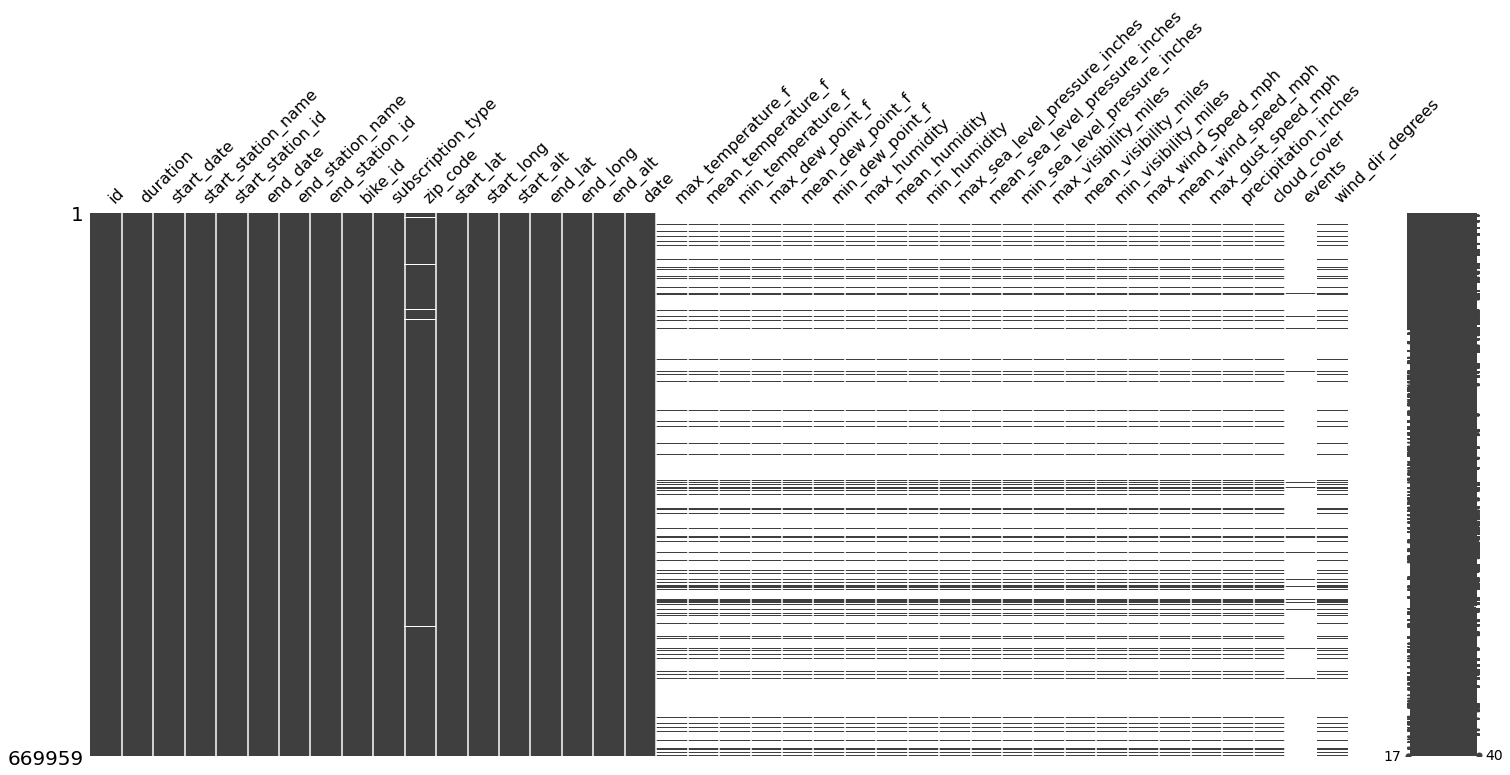

In [40]:
msno.matrix(df)

In [41]:
df.isna().sum() / len(df)

id                                0.000000
duration                          0.000000
start_date                        0.000000
start_station_name                0.000000
start_station_id                  0.000000
end_date                          0.000000
end_station_name                  0.000000
end_station_id                    0.000000
bike_id                           0.000000
subscription_type                 0.000000
zip_code                          0.009880
start_lat                         0.000000
start_long                        0.000000
start_alt                         0.000000
end_lat                           0.000000
end_long                          0.000000
end_alt                           0.000000
date                              0.000000
max_temperature_f                 0.857770
mean_temperature_f                0.857770
min_temperature_f                 0.857770
max_dew_point_f                   0.858072
mean_dew_point_f                  0.858072
min_dew_poi

In [42]:
df.loc[~df['max_temperature_f'].isna()]['zip_code'].astype('int').value_counts()

94107    78704
94041     5856
95113     4811
94301     3868
94063     2049
Name: zip_code, dtype: int64

Conclusions at this point:

* I have over 600k observations to play with. Seems plenty for ml model. (actually it's really great shapewise)
* There is no missing values in main data (not counting weather data and some zip codes)
* Some zip codes are for some reason encoded as floats (had to use astype)
* At least 85% of weather data is missing

Missing zip codes are not a problem. Spatial data is based on latitudes and longitudes and those are 100% present. Weather data is more troubling. My guess is that zip codes in weather table should not be used as secondary keys, but are just location of weather station thus beeing redundant. We will reload weather data with single key

## 2 Reload weather data

In [43]:
weather_drop = ['max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'events', 'wind_dir_degrees']

In [44]:
df = df.drop(weather_drop, axis=1)

In [45]:
wdf = pd.read_csv(os.path.join(input_data_path, 'weather.csv'))
wdf['date'] = wdf['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').date())
wdf = wdf.loc[wdf['zip_code'] == 94107] # San Francisco, California Zip code
wdf = wdf.drop(['zip_code', 'events'], axis=1)

In [46]:
wdf.shape

(733, 22)

In [47]:
len(df['date'].unique())

733

In [48]:
df['date'] = pd.to_datetime(df['start_date'], format='%m/%d/%Y %H:%M')
df['date'] = df['date'].apply(lambda x: x.date())

In [49]:
df = pd.merge(df, wdf, how='left', on='date')

In [50]:
df.shape

(669959, 39)

<AxesSubplot:>

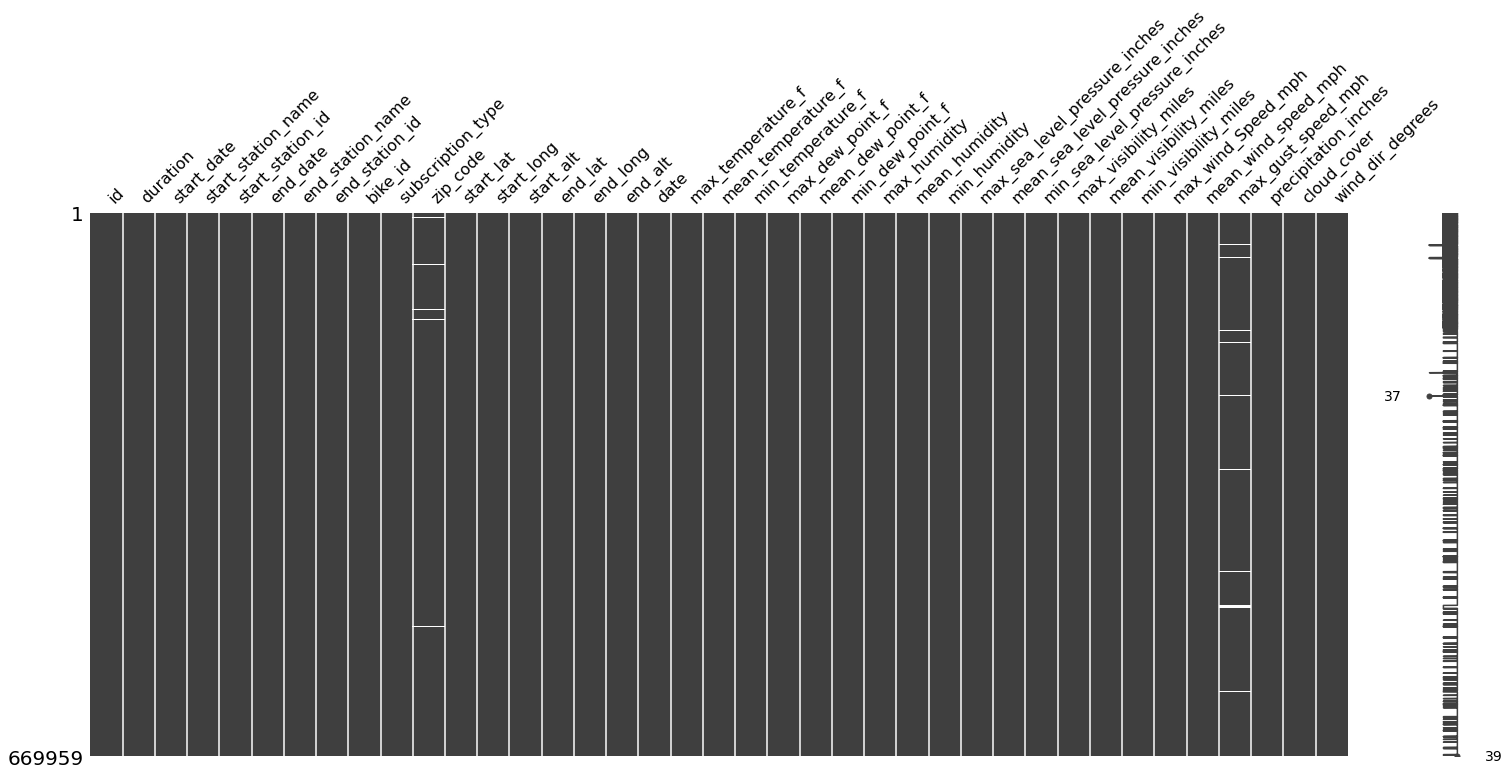

In [51]:
msno.matrix(df)

In [52]:
df.isna().sum() / len(df)

id                                0.000000
duration                          0.000000
start_date                        0.000000
start_station_name                0.000000
start_station_id                  0.000000
end_date                          0.000000
end_station_name                  0.000000
end_station_id                    0.000000
bike_id                           0.000000
subscription_type                 0.000000
zip_code                          0.009880
start_lat                         0.000000
start_long                        0.000000
start_alt                         0.000000
end_lat                           0.000000
end_long                          0.000000
end_alt                           0.000000
date                              0.000000
max_temperature_f                 0.000000
mean_temperature_f                0.000000
min_temperature_f                 0.000000
max_dew_point_f                   0.000000
mean_dew_point_f                  0.000000
min_dew_poi

Yep, that's better

## 3 General overview continues

First, let's drop redundant features. Counting features as redundant if:

* Is non significant id
* I'm certain is not obtainable in production (eg. subscription type)
* Significant part is missing

In [53]:
to_drop = [
    'id',
    'start_date', 
    'start_station_name',
    'start_station_id',
    'end_date', 
    'end_station_name', 
    'end_station_id',
    'bike_id', 
    'subscription_type',
    'zip_code',
    'date', 
    'max_gust_speed_mph',
    'precipitation_inches', 
    'cloud_cover'
]

df = df.drop(to_drop, axis=1)

In [54]:
df.dtypes

duration                            int64
start_lat                         float64
start_long                        float64
start_alt                         float64
end_lat                           float64
end_long                          float64
end_alt                           float64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               

In [55]:
df.describe()

,duration,start_lat,start_long,start_alt,end_lat,end_long,end_alt,max_temperature_f,mean_temperature_f,min_temperature_f,...,min_humidity,max_sea_level_pressure_inches,mean_sea_level_pressure_inches,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,wind_dir_degrees
count,6.699590e+05,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,...,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000,669959.000000
mean,1.107950e+03,37.745599,-122.359477,9.000508,37.745323,-122.359206,8.398029,69.173020,61.064732,52.496005,...,50.782490,30.066458,30.014583,29.961462,9.985662,9.593642,8.018197,18.877173,8.244424,259.522390
std,2.225544e+04,0.125580,0.127874,7.965501,0.125509,0.127809,7.593353,7.083814,5.951794,6.256417,...,13.554825,0.130059,0.125143,0.124254,0.198434,0.980481,2.740921,5.521110,3.531769,63.262505
min,6.000000e+01,37.329732,-122.418954,2.324086,37.329732,-122.418954,2.324086,47.000000,41.000000,32.000000,...,13.000000,29.500000,29.430000,29.390000,6.000000,4.000000,0.000000,5.000000,0.000000,1.000000
25%,3.440000e+02,37.776617,-122.403234,2.835006,37.776617,-122.403234,2.835006,64.000000,57.000000,48.000000,...,43.000000,29.970000,29.920000,29.880000,10.000000,10.000000,7.000000,16.000000,6.000000,256.000000
50%,5.170000e+02,37.785299,-122.397086,5.421002,37.784878,-122.396236,4.575804,69.000000,61.000000,53.000000,...,53.000000,30.050000,30.000000,29.950000,10.000000,10.000000,10.000000,20.000000,8.000000,276.000000
75%,7.550000e+02,37.792251,-122.394203,13.151367,37.792251,-122.394203,12.183614,73.000000,66.000000,57.000000,...,60.000000,30.150000,30.100000,30.040000,10.000000,10.000000,10.000000,22.000000,10.000000,294.000000
max,1.727040e+07,37.804770,-121.877349,31.666592,37.804770,-121.877349,31.666592,93.000000,77.000000,65.000000,...,86.000000,30.470000,30.400000,30.350000,10.000000,10.000000,10.000000,43.000000,22.000000,360.000000


## 4. Response variable

In [56]:
# seconds to minutes
df['duration'] = df['duration'].apply(lambda x: x / 60)

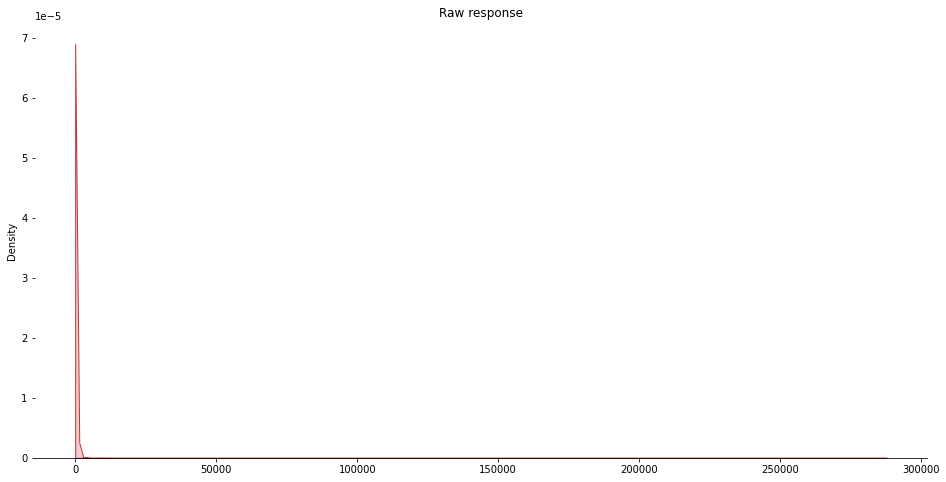

In [57]:
plt.figure(figsize=(16, 8))
plt.title('Raw response')
sns.kdeplot(df['duration'].values, shade=True)
sns.despine(left=True)

Wow, that is a long trip, innit ? Let's look at possible duration cap

In [58]:
df.loc[df['duration'] > 60].shape

(21242, 25)

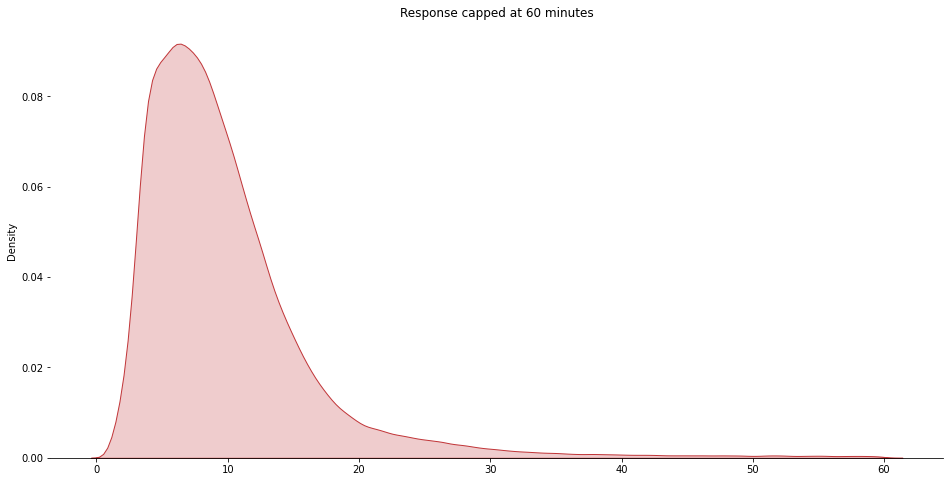

In [59]:
plt.figure(figsize=(16, 8))
plt.title('Response capped at 60 minutes')
sns.kdeplot(df.loc[df['duration'] < 60]['duration'].values, shade=True)
sns.despine(left=True)

60 minutes still leaves a long tail. Coud just log response to catch those, but I'm interested in direct A -> B trips, not tourism. Let's cap trip duration at 40 minutes

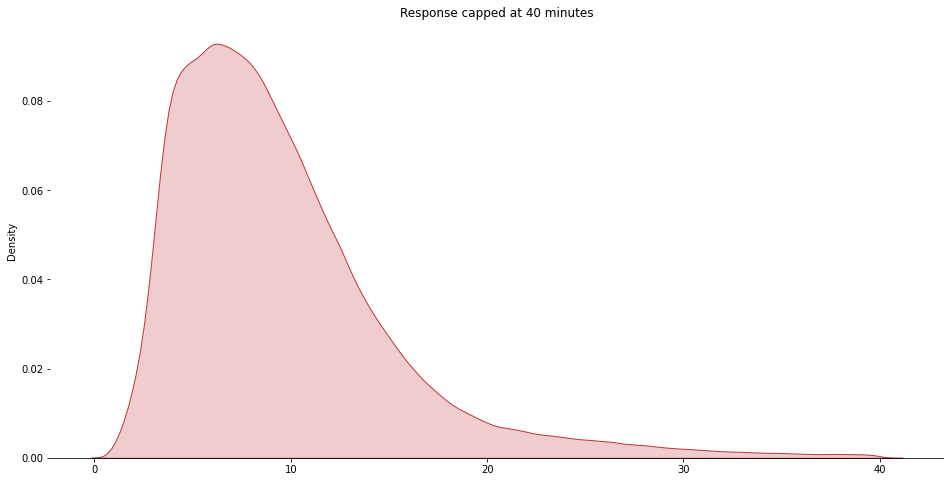

In [60]:
plt.figure(figsize=(16, 8))
plt.title('Response capped at 40 minutes')
sns.kdeplot(df.loc[df['duration'] < 40]['duration'].values, shade=True)
sns.despine(left=True)

In [61]:
df.loc[df['duration'] > 40].shape

(27693, 25)

Log probably still going to be required, but now it looks reasonable. Now let's asses min values. Im looking for trips starting and ending in the same spot

In [62]:
df.loc[(df['start_lat'] == df['end_lat']) & (df['start_long'] == df['end_long'])].shape

(23981, 25)

In [63]:
df = df.loc[(df['start_lat'] != df['end_lat']) & (df['start_long'] != df['end_long']) & (df['duration'] <= 40)]

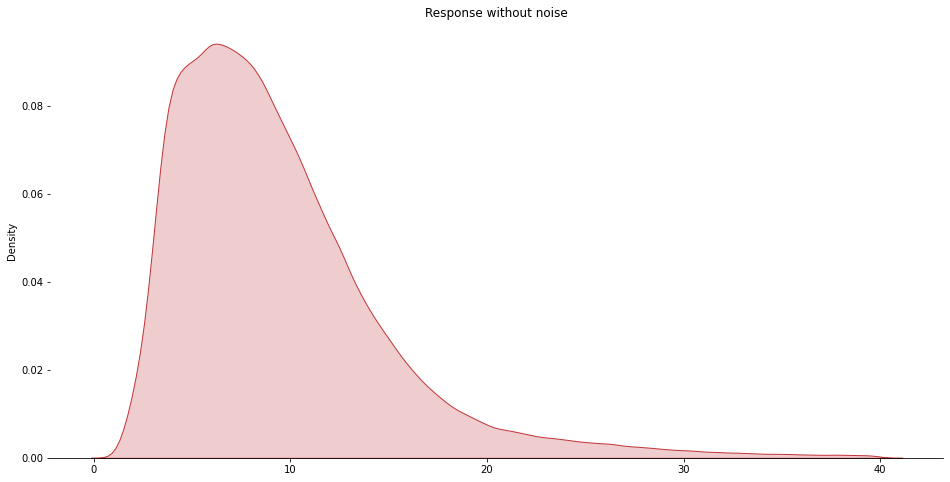

In [64]:
plt.figure(figsize=(16, 8))
plt.title('Response without noise')
sns.kdeplot(df['duration'].values, shade=True)
sns.despine(left=True)

In [65]:
df.shape

(629309, 25)

So I've dropped 40k observations, but what's left are direct A -> B trips. Rest was just unnecesary variance.

## 5. Geospatial analysis

Let's get general overview of location

In [ ]:
stations = df[['start_lat', 'start_long', 'end_lat', 'end_long']].drop_duplicates()

In [70]:
# city_map = folium.Map(location=[stations['start_lat'].mean(), stations['start_long'].mean()], zoom_start=10)

# for _, row in stations.iterrows():
#   folium.Marker([row['start_lat'], row['start_long']], tooltip='lat: {} | long: {}'.format(row['start_lat'], row['start_long'])).add_to(city_map)

# city_map

So bike stations are actually spreading throught couple cities. Let's see if somebody actually rides from southern points to SF

In [71]:
# city_map_b = folium.Map(location=[stations['start_lat'].mean(), stations['start_long'].mean()], zoom_start=10)

# for index,row in stations.iterrows():
#     points = []
#     points.append(tuple([row['start_lat'],row['start_long']]))
#     points.append(tuple([row['end_lat'],row['end_long']]))
#     folium.PolyLine(points, color='#cb0000', weight=1).add_to(city_map_b)

# city_map_b

There seems to be lone connection from Redwood City to SF, but nothing from regions of Palo Alto and San Jose. Im going to limit latitude to 37.7 degrees

In [68]:
df = df.loc[(df['start_lat'] > 37.7) & (df['end_lat'] > 37.7)]

In [69]:
stations = df[['start_lat', 'start_long', 'end_lat', 'end_long']].drop_duplicates()
city_map3 = folium.Map(location=[stations['start_lat'].mean(), stations['start_long'].mean()], zoom_start=13)

for _, row in stations.iterrows():
  folium.Marker([row['start_lat'], row['start_long']], tooltip='lat: {} | long: {}'.format(row['start_lat'], row['start_long'])).add_to(city_map3)

city_map3

Yep, now it looks right. Let's see distribution of response variable after this operation

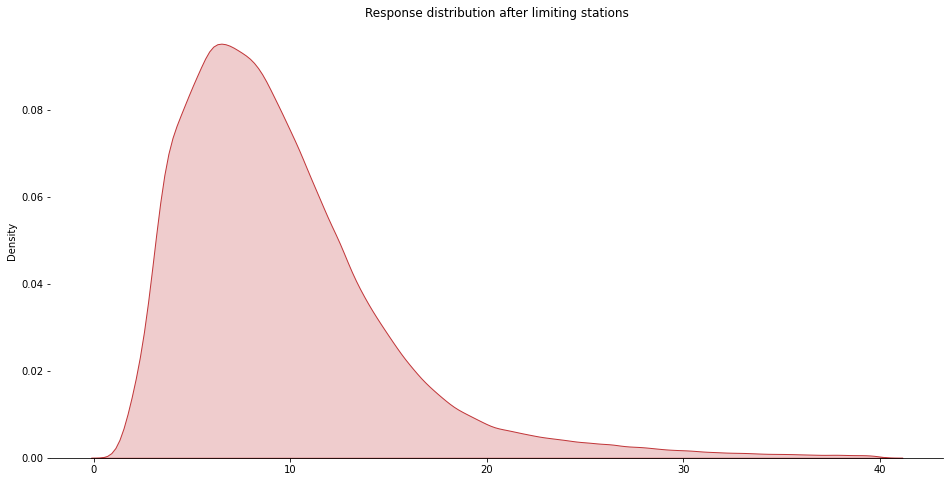

In [72]:
plt.figure(figsize=(16, 8))
plt.title('Response distribution after limiting stations')
sns.kdeplot(df['duration'].values, shade=True)
sns.despine(left=True)

### 5.1. Altitudes 

In [73]:
df.columns

Index(['duration', 'start_lat', 'start_long', 'start_alt', 'end_lat',
       'end_long', 'end_alt', 'max_temperature_f', 'mean_temperature_f',
       'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f',
       'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'wind_dir_degrees'],
      dtype='object')

In [74]:
alts = df[['start_lat', 'start_long', 'start_alt']].drop_duplicates()
alts = alts.pivot(index='start_lat', columns='start_long', values='start_alt')

<AxesSubplot:>

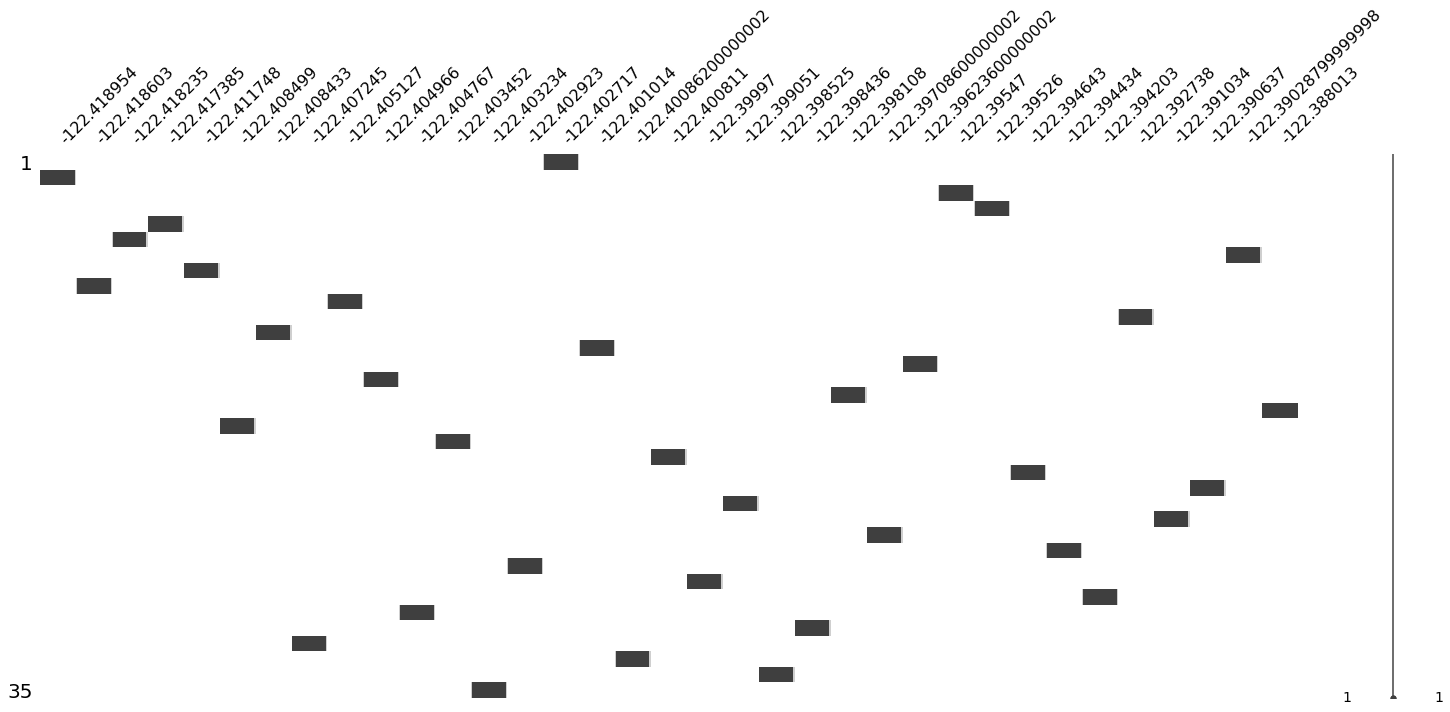

In [75]:
msno.matrix(alts)

My plan is to make heatmaps of altitudes around our ROI, but obviously I've only got data for bicycle stations. No other way than get all lon lat combinations and use ol' elevation API again.

In [76]:
len(alts.index.tolist()) * len(alts.columns.values)

1225

In [77]:
sfcoords = [r for r in itertools.product(alts.index.tolist(), alts.columns.values)]

In [78]:
sfc = {}
idx = 0

for coord in sfcoords:
  sfc[str(idx)] = [coord[0], coord[1]]
  idx += 1

In [102]:
alts_tmp = pd.read_json(os.path.join("../data/external", 'coordinate-altitudes-all.json'), orient='index')

In [103]:
alts = pd.DataFrame(alts_tmp)
alts[['lat','long']] = pd.DataFrame(alts_tmp.data.values.tolist(), index= alts_tmp.index)
alts = alts.drop(['data'], axis=1)

In [104]:
alts.head()

,altitude,lat,long
0,9.072820,37.771058,-122.418954
1,8.717177,37.771058,-122.418603
2,8.461811,37.771058,-122.418235
3,7.837015,37.771058,-122.417385
4,6.205472,37.771058,-122.411748


In [105]:
altsp = alts.pivot(index='lat', columns='long', values='altitude')

In [106]:
altsp = altsp.sort_index(ascending=False)

<AxesSubplot:xlabel='long', ylabel='lat'>

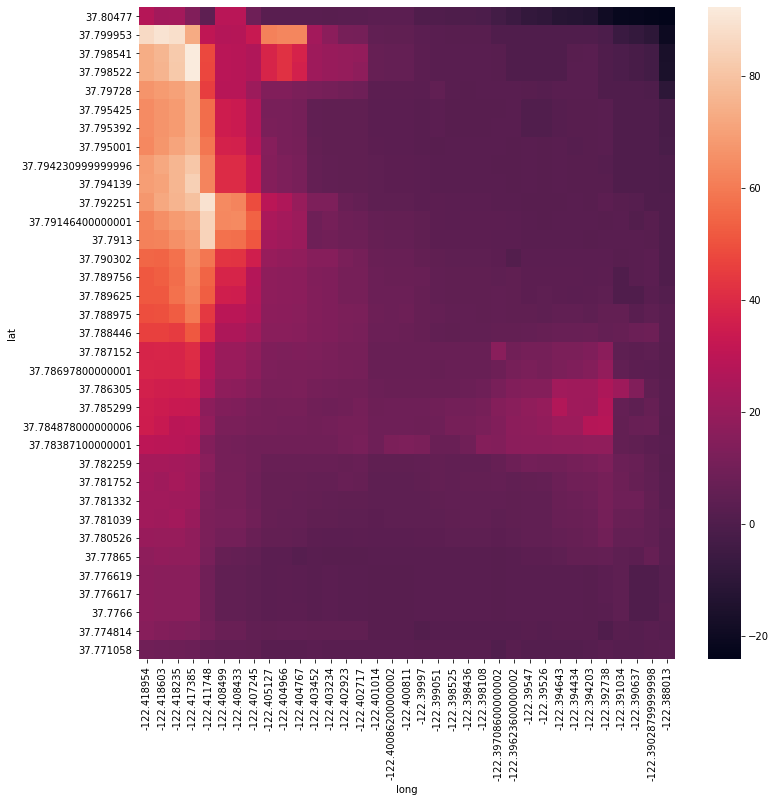

In [107]:
plt.figure(figsize=(12, 12))
sns.heatmap(altsp)

In [108]:
alts.head()

,altitude,lat,long
0,9.072820,37.771058,-122.418954
1,8.717177,37.771058,-122.418603
2,8.461811,37.771058,-122.418235
3,7.837015,37.771058,-122.417385
4,6.205472,37.771058,-122.411748


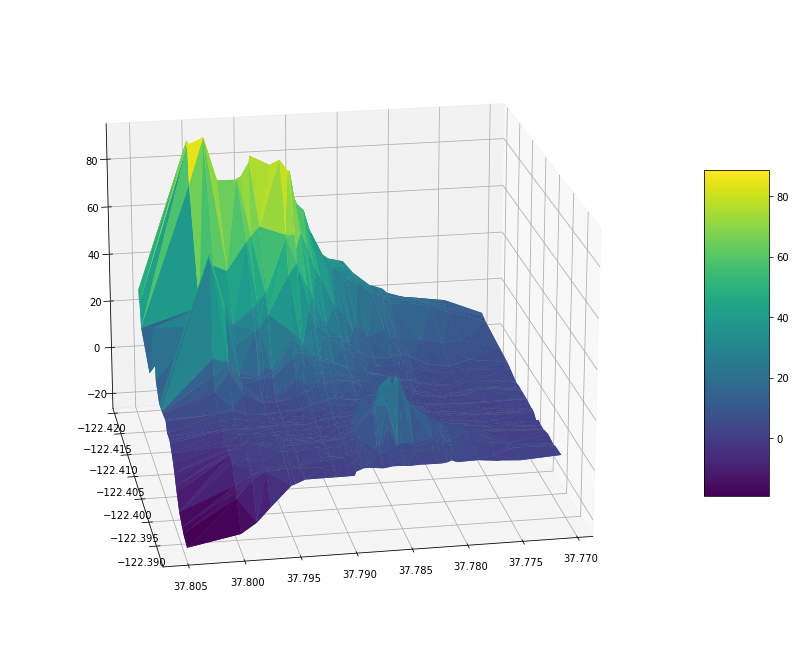

In [109]:
fig = plt.figure(figsize=(16, 12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(alts['lat'], alts['long'], alts['altitude'], cmap=plt.cm.viridis, linewidth=0.2)
 
surf=ax.plot_trisurf(alts['lat'], alts['long'], alts['altitude'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
 
ax.view_init(20, 80)
plt.show()

Looking at heatmaps (especially 2D) I can say that my prior assuption about altitude difference between start and stop points might not be true. Stations are placed on flat areas of SF. 

In [110]:
alt_diffs = [row['end_alt'] - row['start_alt'] for _, row in df.iterrows()]

/Users/rajesh/work/projects/learning/machine-learning/venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


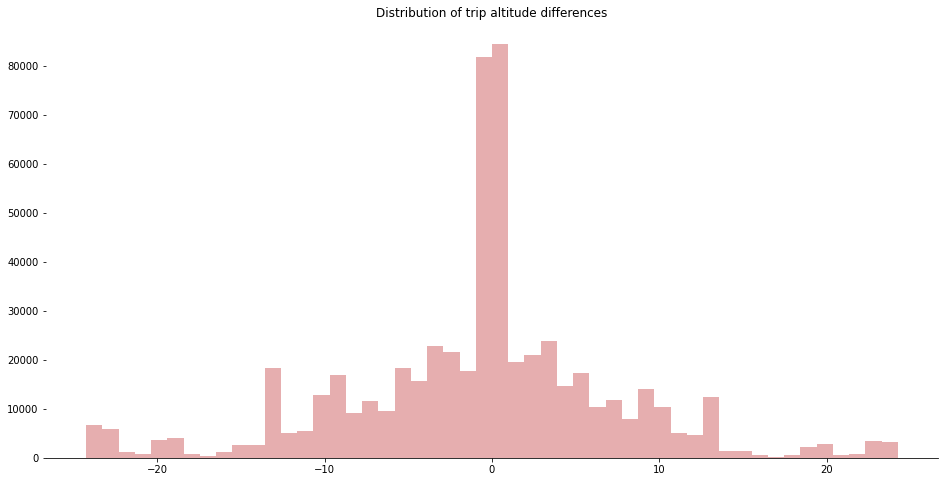

In [111]:
plt.figure(figsize=(16, 8))
plt.title('Distribution of trip altitude differences')
sns.distplot(alt_diffs, kde=False)
sns.despine(left=True)

### 5.2. Distances

Now it's time to calculate distance based on latitudes and longitudes. I'm going to use [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)

In [112]:
def haversine_distance(p1, p2):
  """
  https://en.wikipedia.org/wiki/Haversine_formula
  """
  R = 6373.0
  
  p1 = [radians(x) for x in p1]
  p2 = [radians(x) for x in p2]
  
  diff = [a - b for a, b in zip(p1, p2)]
  a = sin(diff[0] / 2) ** 2 + cos(p1[0]) * cos(p2[0]) * sin(diff[1] / 2) ** 2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))
  dist = R * c
  
  return dist

In [113]:
df.head()

,duration,start_lat,start_long,start_alt,end_lat,end_long,end_alt,max_temperature_f,mean_temperature_f,min_temperature_f,...,min_humidity,max_sea_level_pressure_inches,mean_sea_level_pressure_inches,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,wind_dir_degrees
1,17.783333,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,74.0,68.0,61.0,...,57.0,30.07,30.02,29.97,10.0,10.0,10.0,23.0,11.0,286.0
2,18.850000,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,74.0,68.0,61.0,...,57.0,30.07,30.02,29.97,10.0,10.0,10.0,23.0,11.0,286.0
3,18.616667,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,74.0,68.0,61.0,...,57.0,30.07,30.02,29.97,10.0,10.0,10.0,23.0,11.0,286.0
4,18.633333,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,74.0,68.0,61.0,...,57.0,30.07,30.02,29.97,10.0,10.0,10.0,23.0,11.0,286.0
7,12.733333,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,74.0,68.0,61.0,...,57.0,30.07,30.02,29.97,10.0,10.0,10.0,23.0,11.0,286.0


In [114]:
df['distance'] = df.apply(lambda row: haversine_distance([row['start_lat'], row['start_long']], [row['end_lat'], row['end_long']]), axis=1)

/Users/rajesh/work/projects/learning/machine-learning/venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


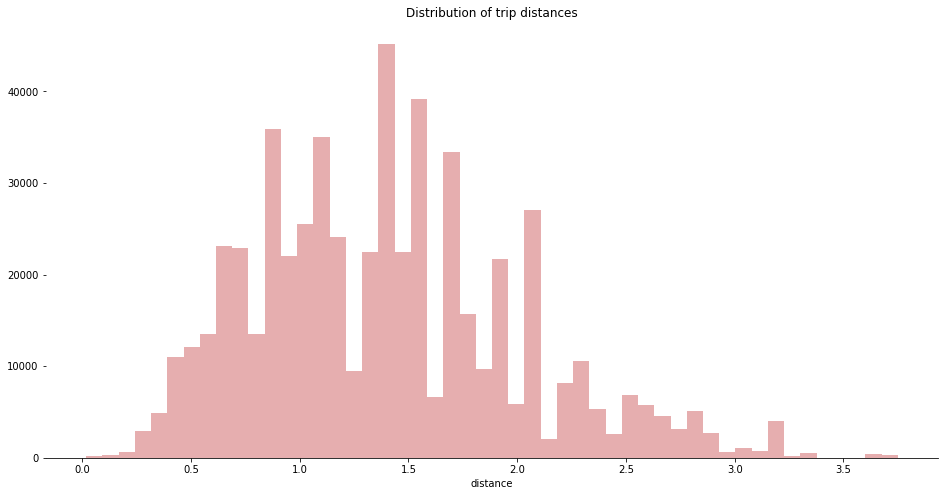

In [115]:
plt.figure(figsize=(16, 8))
plt.title('Distribution of trip distances')
sns.distplot(df['distance'], kde=False)
sns.despine(left=True)

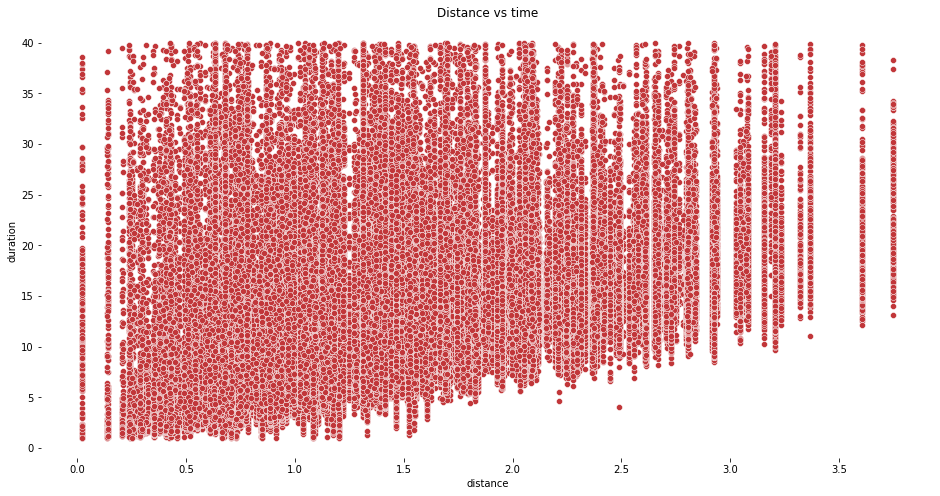

In [116]:
plt.figure(figsize=(16, 8))
plt.title('Distance vs time')
sns.scatterplot(x=df['distance'], y=df['duration'])
sns.despine(left=True, bottom=True)

After calculating distances (in km) and plotting them against trip duration there are two things I'ld like to point out:

* There is still a lot of noise (200m trip taking ~40 mins ?)
* Distance looks almost like categorical variable due to fixed number of stations, so maybe it should be binned ?

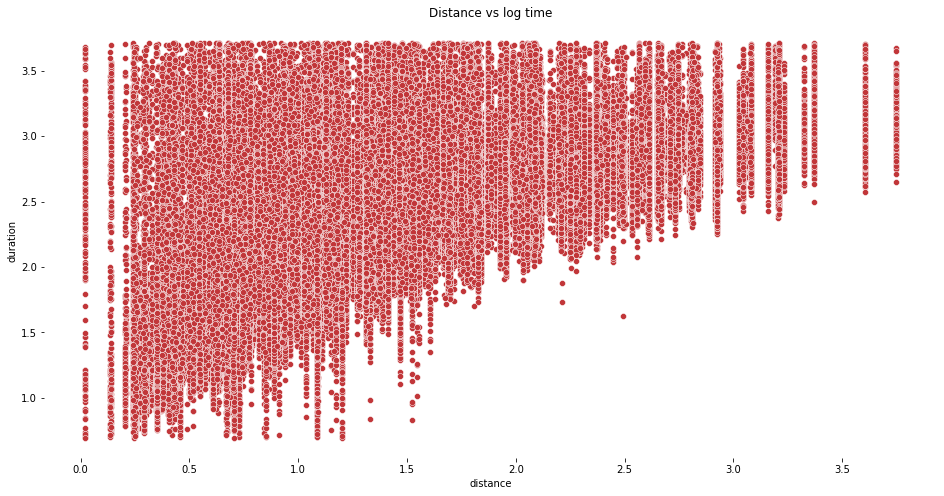

In [117]:
plt.figure(figsize=(16, 8))
plt.title('Distance vs log time')
sns.scatterplot(x=df['distance'], y=np.log1p(df['duration']))
sns.despine(left=True, bottom=True)

In [118]:
enc = KBinsDiscretizer(n_bins=3, encode='ordinal')
dist_binned = enc.fit_transform(df['distance'].values.reshape(-1, 1))

In [119]:
dist_binned.shape

(571080, 1)

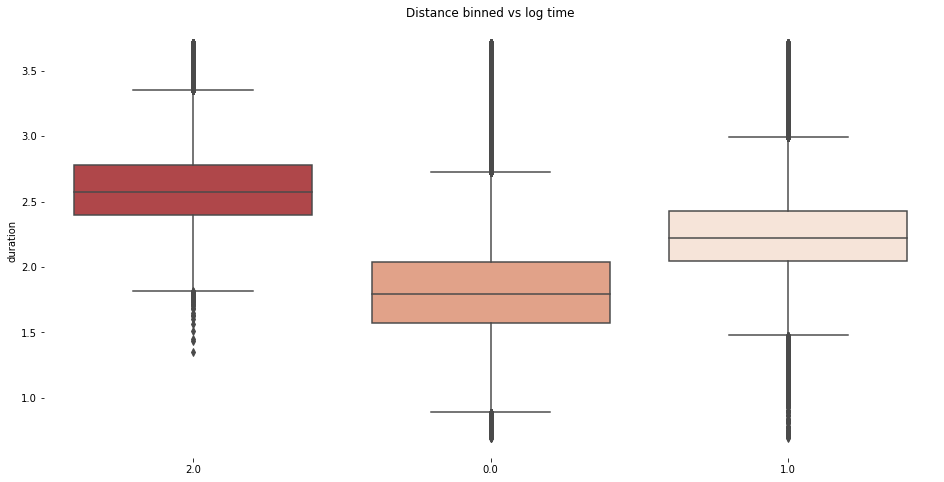

In [120]:
plt.figure(figsize=(16, 8))
plt.title('Distance binned vs log time')
sns.boxplot(x=dist_binned.astype('str').flatten(), y=np.log1p(df['duration']))
sns.despine(left=True, bottom=True)

Binning seems to be a good idea. This may turn out as very simple model if I find a way to remove noise from short  and mid trip durations. Maybe [this](https://en.wikipedia.org/wiki/Mahalanobis_distance) ?

### 5.3. Weather

I wasn't  sure if i could even use weather features due to limitations in production environment. However I've stumbled upon [this API](https://openweathermap.org/current). Let's look at sample response:

```
{"coord": { "lon": 139,"lat": 35},
  "weather": [
    {
      "id": 800,
      "main": "Clear",
      "description": "clear sky",
      "icon": "01n"
    }
  ],
  "base": "stations",
  "main": {
    "temp": 289.92,
    "pressure": 1009,
    "humidity": 92,
    "temp_min": 288.71,
    "temp_max": 290.93
  },
  "wind": {
    "speed": 0.47,
    "deg": 107.538
  },
  "clouds": {
    "all": 2
  },
  "dt": 1560350192,
  "sys": {
    "type": 3,
    "id": 2019346,
    "message": 0.0065,
    "country": "JP",
    "sunrise": 1560281377,
    "sunset": 1560333478
  },
  "timezone": 32400,
  "id": 1851632,
  "name": "Shuzenji",
  "cod": 200
}
```

Looks like I'll be able to use:

* mean temperature
* max and min temperature
* mean humidity
* mean sea level pressure
* mean wind speed
* wind dir in degrees

Let's take a closer look at those feats

In [121]:
weather_feats = ['max_temperature_f',	'mean_temperature_f',	'min_temperature_f',
                 'mean_humidity', 'mean_sea_level_pressure_inches', 
                 'mean_wind_speed_mph',	'wind_dir_degrees', 'duration']

In [122]:
dfw = df[weather_feats]

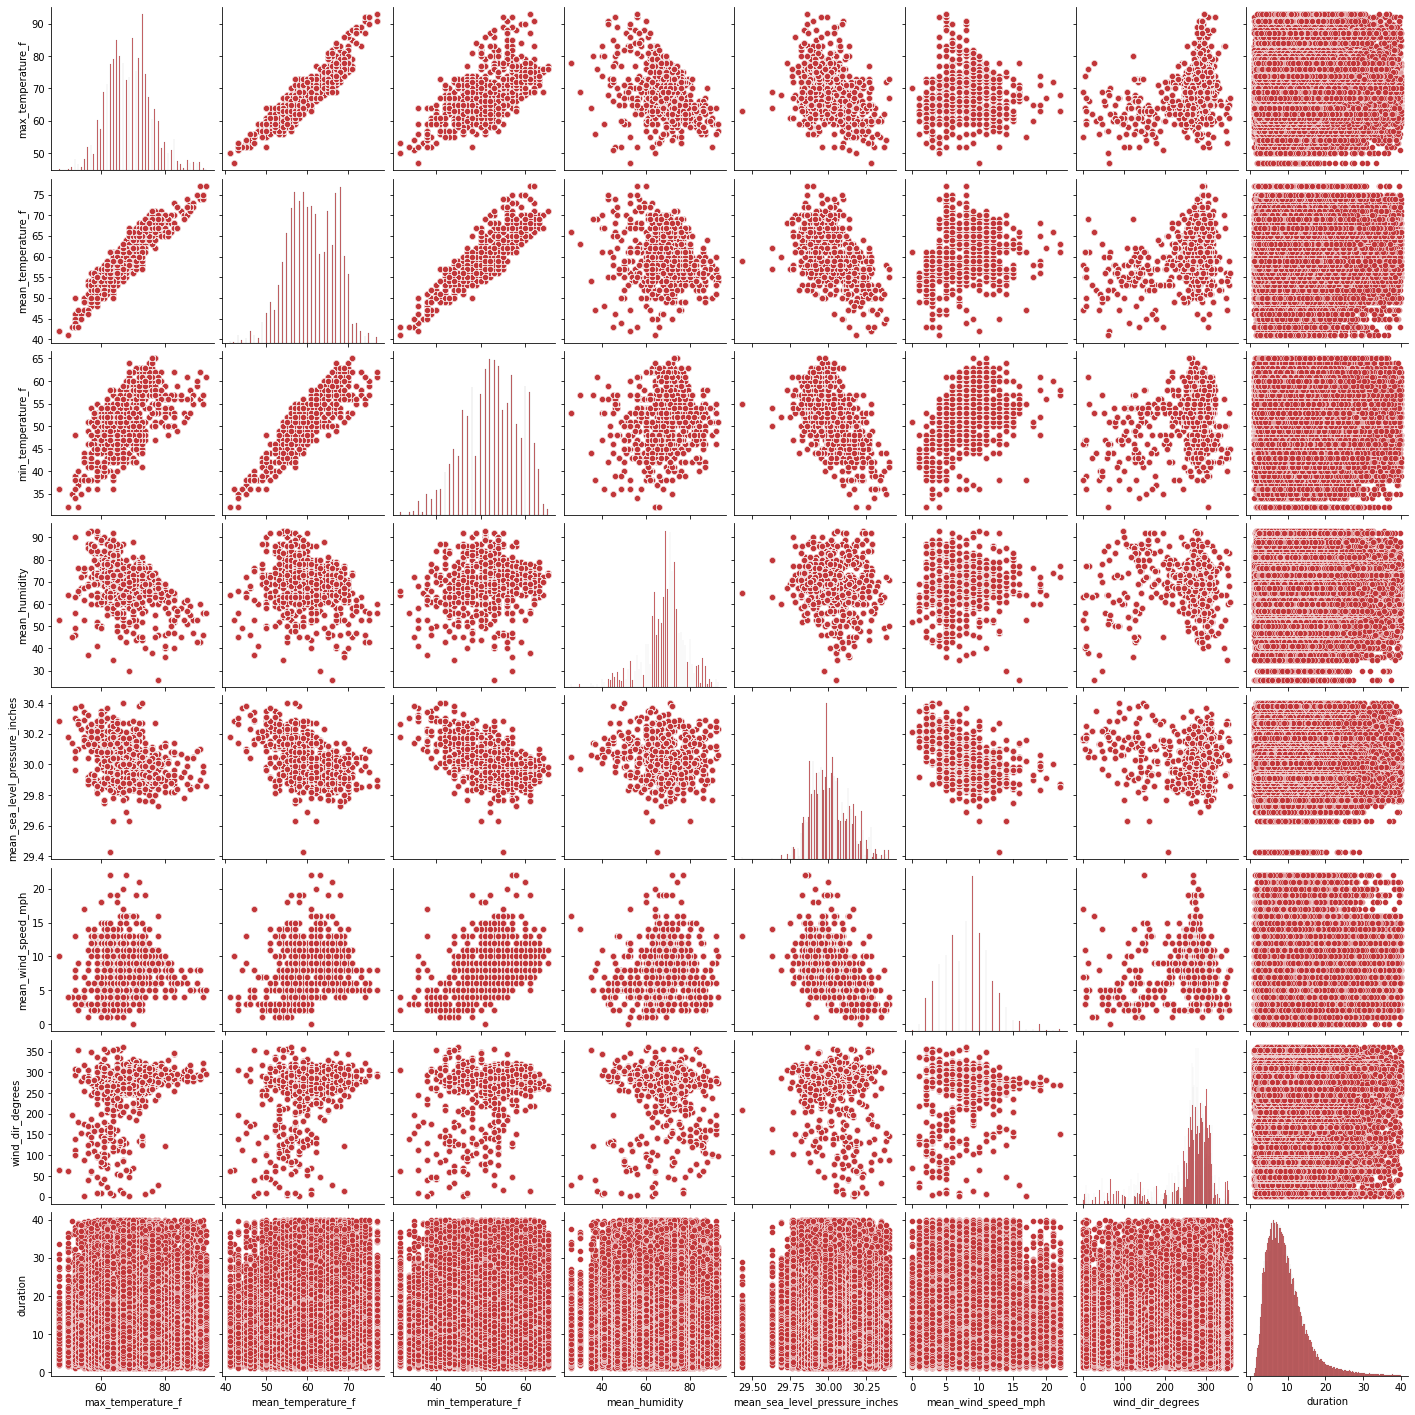

In [124]:
sns.pairplot(dfw)

Well, weather features might be redundant anyway. Looks like absolutly no correlation whatsoever.

<AxesSubplot:>

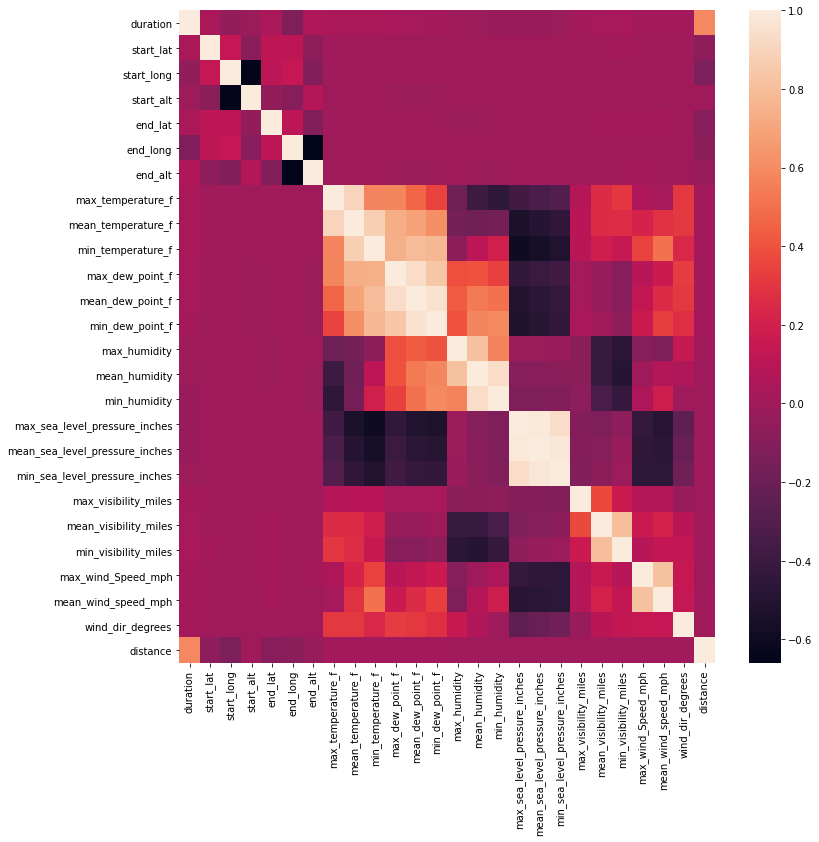

In [125]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr())

## 6. EDA summary

So let's reflect on prior assumptions:

* Travel times are correlated to distance.
** This unsurprisingly is going to be most important feature. Main goal is to reduce last bit of noise using mahalanobis distances in bins. If this succeds, model is going to be unfortunately a bit trivial.
* Change in altitudes between different stations significantly affects travel times
** Low correlation indicates otherwise. Looking at the altitude maps I can see that stations were placed in the lower pats of SV avoiding hills (which is reasonable). However imgoing to leave this feature in for now.
* Weather affects travel times (especially temperature, humidity)
** Nope. Weather data seems to be useless.
* Some trips in dataset were done by tourists, so they should be removed
** This assumption was entirely correct. In fact most of this notebook was about cleaning response variable.


In [126]:
dropcols = ['max_temperature_f',	'mean_temperature_f',	'min_temperature_f',
            'mean_humidity', 'mean_sea_level_pressure_inches', 
            'mean_wind_speed_mph', 'wind_dir_degrees', 'max_dew_point_f',
            'mean_dew_point_f',	'min_dew_point_f',	'max_humidity',	'min_humidity',
            'max_sea_level_pressure_inches',	'min_sea_level_pressure_inches',	
            'max_visibility_miles',	'mean_visibility_miles',	
            'min_visibility_miles',	'max_wind_Speed_mph']

df = df.drop(dropcols, axis=1)

In [127]:
df.head()

,duration,start_lat,start_long,start_alt,end_lat,end_long,end_alt,distance
1,17.783333,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195
2,18.850000,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195
3,18.616667,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195
4,18.633333,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195
7,12.733333,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195


In [128]:
df.to_csv(os.path.join(processed_data_path, 'sfbike_preprocessed.csv'))